In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# utilities:
def load_spectrum(filename):
  number_channels = 1016
  # print(f'loading data from : "{filename}"')
  f = open(filename, 'r')
  data = [[float(item2) for item2 in item.split('\t') if len(item2) > 0]
    for item in f.read().split('\n') if len(item) > 0]
  data_unique = set([len(item) for item in data])
  if len(data) != number_channels:
    print(f'ERROR: Total number of channels is not {number_channels}.')
    exit()
  elif data_unique == {2} or data_unique == {3}:
    energy = np.array([item[0] for item in data])
    counts = np.array([item[1] for item in data])
    if 'Exp' in filename:
      # i.e., if spectrum is NaI generated, normalize w.r.t aquisition time:
      aquisition_time = int([item for item in filename.split('_') if 'sec' in item][0].split('sec')[0])
      counts = counts/aquisition_time
    if data_unique == {2}:
      percentage_error = np.empty(energy.shape)*np.nan
    elif data_unique == {3}:
      percentage_error = np.array([item[1] for item in data])
    return energy, counts, percentage_error
  else:
    print('ERROR: At some point or all, spectrum data format does not match with either "Energy\tcounts" or "Energy\tcounts\tError".')
    exit()
  print('ERROR: cannot load spectrum data')
  exit()


In [3]:
# initialization:
class_labels = {
  'bkg':   0,
  'Ba133': 1,
  'Cs137': 2,
  'Co60':  3
}
num_classes = len(class_labels)

In [4]:
'''
D7: simulated data - used for training
D7: simulated data - used for evaluation
D8: experimental data - used for evaluation
'''


for combination in [['D7', 'train'], ['D8', 'test'], ['D9', 'test']]:
  print('\n', combination)
  directory, datafilename = combination[0], combination[1]

  rn_tag = 'bkg_Exp_base'
  filename = [item for item in os.listdir('base_spectrums') if rn_tag in item][0]
  spect_class0 = load_spectrum(f'base_spectrums/{filename}')

  RN = 'Ba133'
  rn_tag = f'{RN}_FLUKA_base' if directory in ['D7', 'D8'] else f'{RN}_Exp_base'
  filename = [item for item in os.listdir('base_spectrums') if rn_tag in item][0]
  spect_class1 = load_spectrum(f'base_spectrums/{filename}')
  
  RN = 'Cs137'
  rn_tag = f'{RN}_FLUKA_base' if directory in ['D7', 'D8'] else f'{RN}_Exp_base'
  filename = [item for item in os.listdir('base_spectrums') if rn_tag in item][0]
  spect_class2 = load_spectrum(f'base_spectrums/{filename}')
  
  RN = 'Co60'
  rn_tag = f'{RN}_FLUKA_base' if directory in ['D7', 'D8'] else f'{RN}_Exp_base'
  filename = [item for item in os.listdir('base_spectrums') if rn_tag in item][0]
  spect_class3 = load_spectrum(f'base_spectrums/{filename}')

  '''
  NOTE:
  min and max energy values are same for simulated and experimental data
  #energy_bins (i.e #channels or #features) are also same for simulated and experimental data
  however, the energy bin boundaries are not exactly same
  hence, for mixing the spectrums (simulated + experimental), this should be considered.
  (class-0 is always experimenal data since background can be simulated as its origin is natural radioactivity in environment)
  '''
  ene_pairs = [] # corresponding counts shall be added during mixing of spectrums.
  for i in range(len(spect_class0[0])):
    j = np.argmin(np.abs(spect_class1[0] - spect_class0[0][i]))
    ene_pairs.append([i,j])

  # normalize spect w.r.t total counts:
  spect0_norm = [spect_class0[0], spect_class0[1]/spect_class0[1].sum(), spect_class0[2]]
  spect1_norm = [spect_class1[0], spect_class1[1]/spect_class1[1].sum(), spect_class1[2]]
  spect2_norm = [spect_class2[0], spect_class2[1]/spect_class2[1].sum(), spect_class2[2]]
  spect3_norm = [spect_class3[0], spect_class3[1]/spect_class3[1].sum(), spect_class3[2]]

  if directory == 'D7':
    np.random.seed(70)
  if directory == 'D8':
    np.random.seed(80)
  if directory == 'D9':
    np.random.seed(90)

  csv = []  # to collect produced spectrums
  for ID in range(5000):
    '''
    Now,
    the relative fraction of composition ~ random.uniform(low=0.0, high=1.0)
    '''
    fr0 = np.random.uniform(low=0.0, high=1.0)
    fr1 = np.random.uniform(low=0.0, high=1.0)
    fr2 = np.random.uniform(low=0.0, high=1.0)
    fr3 = np.random.uniform(low=0.0, high=1.0)
    fr_sum = fr0 + fr1 + fr2 + fr3
    fr0, fr1, fr2, fr3 = fr0/fr_sum, fr1/fr_sum, fr2/fr_sum, fr3/fr_sum

    # the superimposed spetrum:
    # energy-wise addition:
    if directory in ['D7', 'D8']:  # D7 and D8 contains simulated data but class-0 spectrum is always experimental
      counts = []
      for ene in ene_pairs:
        counts.append(fr0*spect0_norm[1][ene[0]] + fr1*spect1_norm[1][ene[1]] +
                      fr2*spect2_norm[1][ene[1]] + fr3*spect3_norm[1][ene[1]])
      counts = np.array(counts)
    else:  # for D9: purely experimental data ==> energy bins are same for all spectrums
      counts = fr0*spect0_norm[1] + fr2*spect1_norm[1] + fr2*spect2_norm[1] + fr3*spect3_norm[1]
    spect_norm = [spect_class0[0], counts/counts.sum(), spect_class0[2]]

    '''
    Now,
    the gross count variation:
    '''
    gross_counts = np.random.uniform(low=500, high=10000)
    good_spect = [spect_norm[0], spect_norm[1]*gross_counts, spect_norm[2]]
    # note: at this point, counts have been scaled but the statistics has not changed.
    # to change the data_statistics, we resample each count from Poission distribution with new_count as expected_count
    counts = []
    for i in range(len(good_spect[1])):
      counts.append(np.random.poisson(lam=good_spect[1][i]))  # resample each count from Poisson distribution with expected_mean = new_count
    counts = np.array(counts)
    bad_spect_norm = [spect_norm[0], counts/counts.sum(), spect_norm[2]]  # re-normalize data w.r.t gross_count
  
    csv.append([ID] + [f'{item}' for item in bad_spect_norm[1]] + [fr0, fr1, fr2, fr3] + [gross_counts])

  csv = [['ID'] + [f'feature_{item}' for item in range(1016)] + ['rf0', 'rf1', 'rf2', 'rf3'] + ['gross_counts']] + csv  # add headers to data

  # export detailed data (including mixing fraction and gross counts - it shall be used during result analysis)
  f = open(f'{directory}/{datafilename}{directory}_detailed.csv', 'w')
  f.write('\n'.join([','.join([str(item2) for item2 in item]) for item in csv]))
  f.close()

  # export training/tessting data (exclude the gross counts)
  f = open(f'{directory}/{datafilename}{directory}.csv', 'w')
  f.write('\n'.join([','.join([str(item2) for item2 in item[:-1]]) for item in csv]))
  f.close()
print('\ndata generation complete.')


 ['D7', 'train']

 ['D8', 'test']

 ['D9', 'test']

data generation complete.



 ['D7', 'train']


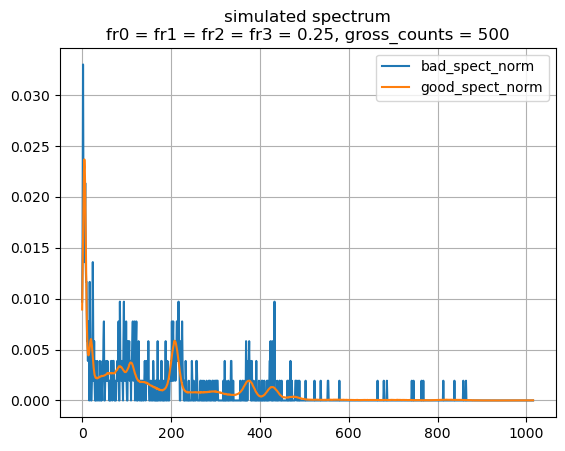

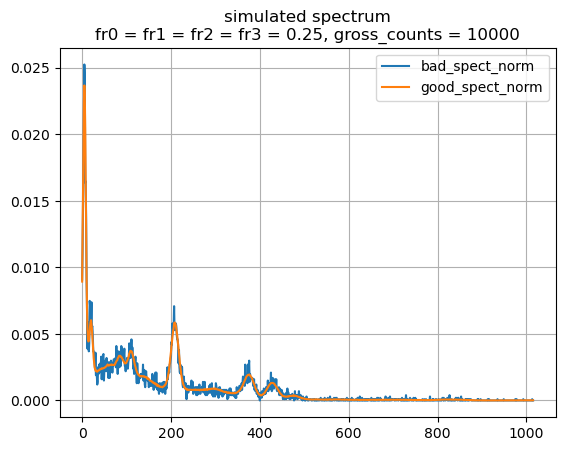


 ['D9', 'test']


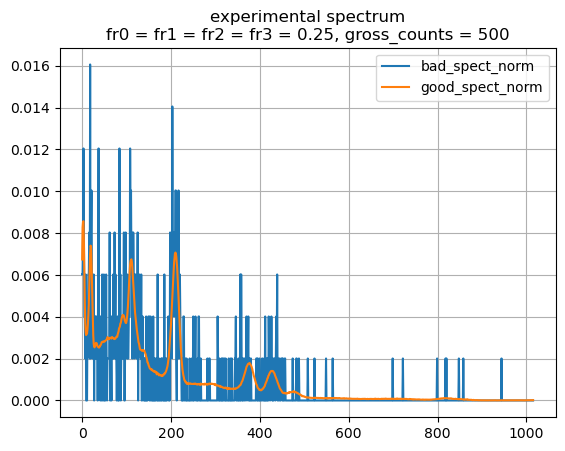

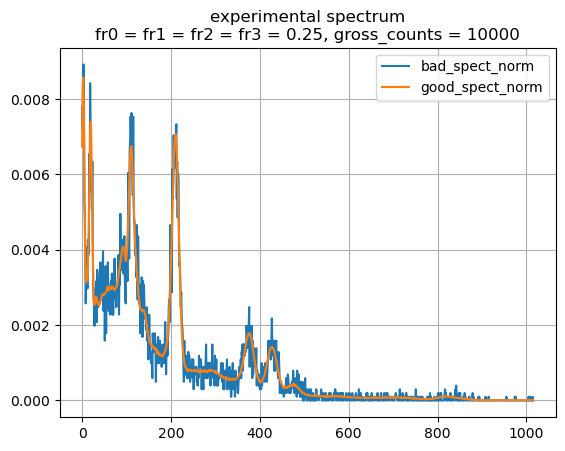


plots complete.


In [5]:
# plot sample spectrums:
for combination in [['D7', 'train'], ['D9', 'test']]:
  print('\n', combination)
  directory, datafilename = combination[0], combination[1]

  rn_tag = 'bkg_Exp_base'
  filename = [item for item in os.listdir('base_spectrums') if rn_tag in item][0]
  spect_class0 = load_spectrum(f'base_spectrums/{filename}')

  RN = 'Ba133'
  rn_tag = f'{RN}_FLUKA_base' if directory in ['D7', 'D8'] else f'{RN}_Exp_base'
  filename = [item for item in os.listdir('base_spectrums') if rn_tag in item][0]
  spect_class1 = load_spectrum(f'base_spectrums/{filename}')
  
  RN = 'Cs137'
  rn_tag = f'{RN}_FLUKA_base' if directory in ['D7', 'D8'] else f'{RN}_Exp_base'
  filename = [item for item in os.listdir('base_spectrums') if rn_tag in item][0]
  spect_class2 = load_spectrum(f'base_spectrums/{filename}')
  
  RN = 'Co60'
  rn_tag = f'{RN}_FLUKA_base' if directory in ['D7', 'D8'] else f'{RN}_Exp_base'
  filename = [item for item in os.listdir('base_spectrums') if rn_tag in item][0]
  spect_class3 = load_spectrum(f'base_spectrums/{filename}')

  ene_pairs = [] # corresponding counts shall be added during mixing of spectrums.
  for i in range(len(spect_class0[0])):
    j = np.argmin(np.abs(spect_class1[0] - spect_class0[0][i]))
    ene_pairs.append([i,j])

  # normalize spect w.r.t total counts:
  spect0_norm = [spect_class0[0], spect_class0[1]/spect_class0[1].sum(), spect_class0[2]]
  spect1_norm = [spect_class1[0], spect_class1[1]/spect_class1[1].sum(), spect_class1[2]]
  spect2_norm = [spect_class2[0], spect_class2[1]/spect_class2[1].sum(), spect_class2[2]]
  spect3_norm = [spect_class3[0], spect_class3[1]/spect_class3[1].sum(), spect_class3[2]]

  for ID in range(1):
    '''
    Now,
    the relative fraction of composition ~ random.uniform(low=0.0, high=1.0)
    '''
    fr0, fr1, fr2, fr3 = 0.25, 0.25, 0.25, 0.25

    # the superimposed spetrum:
    # energy-wise addition:
    if directory in ['D7', 'D8']:  # D7 and D8 contains simulated data but class-0 spectrum is always experimental
      counts = []
      for ene in ene_pairs:
        counts.append(fr0*spect0_norm[1][ene[0]] + fr1*spect1_norm[1][ene[1]] +
                      fr2*spect2_norm[1][ene[1]] + fr3*spect3_norm[1][ene[1]])
      counts = np.array(counts)
    else:  # for D9: purely experimental data ==> energy bins are same for all spectrums
      counts = fr0*spect0_norm[1] + fr2*spect1_norm[1] + fr2*spect2_norm[1] + fr3*spect3_norm[1]
    spect_norm = [spect_class0[0], counts/counts.sum(), spect_class0[2]]

    '''
    Now,
    the gross count variation:
    '''
    for gross_count in [500, 10000]:
      good_spect = [spect_norm[0], spect_norm[1]*gross_count, spect_norm[2]]
      # note: at this point, counts have been scaled but the statistics has not changed.
      # to change the data_statistics, we resample each count from Poission distribution with new_count as expected_count
      counts = []
      for i in range(len(good_spect[1])):
        counts.append(np.random.poisson(lam=good_spect[1][i]))  # resample each count from Poisson distribution with expected_mean = new_count
      counts = np.array(counts)
      bad_spect_norm = [spect_norm[0], counts/counts.sum(), spect_norm[2]]  # re-normalize data w.r.t gross_count
      txt = 'simulated spectrum' if directory in ['D7', 'D8'] else 'experimental spectrum'
      plt.plot(bad_spect_norm[1], label='bad_spect_norm')
      plt.plot(good_spect[1]/good_spect[1].sum(), label='good_spect_norm')
      plt.grid()
      plt.legend()
      plt.title(f'{txt}\nfr0 = fr1 = fr2 = fr3 = 0.25, gross_counts = {gross_count}')
      plt.show()

print('\nplots complete.')